### Gamma Ray Bursts Data Clustering

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

In [46]:
import requests
import numpy as np

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_11224\2158404239.py:10: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt

https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

In [47]:
print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


We have to clean data!\
Some data are flagged by '-999'

In [48]:
T90, flux = zip(*[(float(a), float(b)) for a, b in zip(raw[6], raw[9]) if a != '-999' and b != '-999' and float(b)!=0])

In [49]:
T90  = np.array(T90)
flux = np.array(flux)

In [50]:
T90 = np.log10(T90)
flux= np.log10(flux)

In [51]:
import matplotlib.pyplot as plt
import plot_settings

In [52]:
X = np.vstack([T90, flux])

In [53]:
X = X.T

Text(0, 0.5, 'log(Flux) $\\left[\\frac{\\text{KeV}}{\\text{cm}^2}\\right]$')

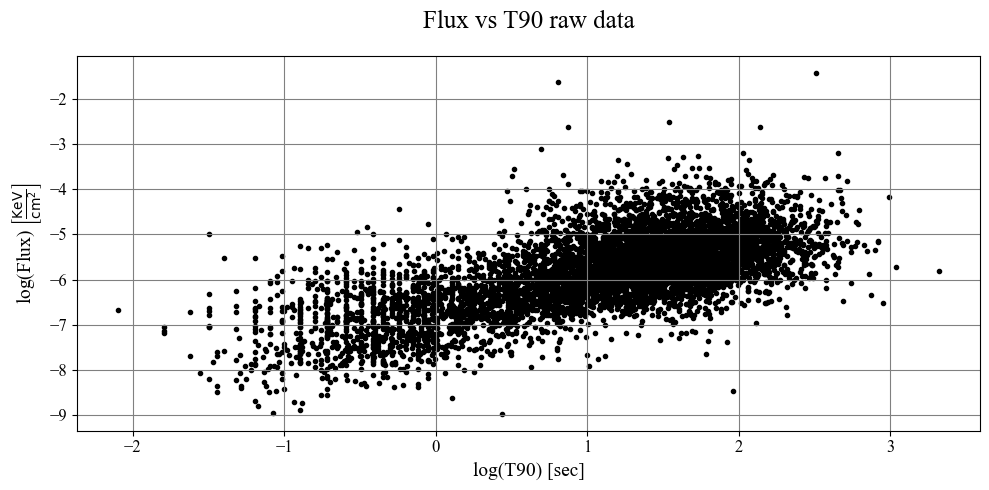

In [54]:
plt.scatter(X[:,0],X[:,1],color='black', marker='.')
plt.title('Flux vs T90 raw data')
plt.xlabel('log(T90) [sec]')
plt.ylabel(r'log(Flux) $\left[\frac{\text{KeV}}{\text{cm}^2}\right]$')

In [55]:
from sklearn.cluster import KMeans

In [56]:
n_clusters = 3

In [57]:
init = np.array([[50, 1e3],[0.5, 1e2]])

In [58]:
instance = KMeans(n_clusters, verbose=1, tol=1e-6, algorithm='elkan')

In [59]:
instance.fit(X)

Initialization complete
Iteration 0, inertia 3365.903172923774
Iteration 1, inertia 2979.391375322891
Iteration 2, inertia 2953.6357336466426
Iteration 3, inertia 2943.365244529835
Iteration 4, inertia 2937.0692362575874
Iteration 5, inertia 2933.3933818220194
Iteration 6, inertia 2930.9690504436703
Iteration 7, inertia 2929.565267131096
Iteration 8, inertia 2928.9351580839966
Iteration 9, inertia 2928.653913767465
Iteration 10, inertia 2928.5137680256403
Iteration 11, inertia 2928.406902436877
Iteration 12, inertia 2928.335534081806
Iteration 13, inertia 2928.2965262770185
Iteration 14, inertia 2928.266390770211
Iteration 15, inertia 2928.2008911515913
Iteration 16, inertia 2928.142040020757
Iteration 17, inertia 2928.0804093046854
Iteration 18, inertia 2928.041136789637
Iteration 19, inertia 2927.999133095661
Iteration 20, inertia 2927.9431379064035
Iteration 21, inertia 2927.91598926209
Iteration 22, inertia 2927.891999350334
Iteration 23, inertia 2927.879559697524
Iteration 24, ine

KMeans(algorithm='elkan', n_clusters=3, tol=1e-06, verbose=1)

In [60]:
centers = instance.cluster_centers_ #location of the clusters
labels = instance.predict(X) #labels for each of the points

In [61]:
np.unique(labels)

array([0, 1, 2], dtype=int32)

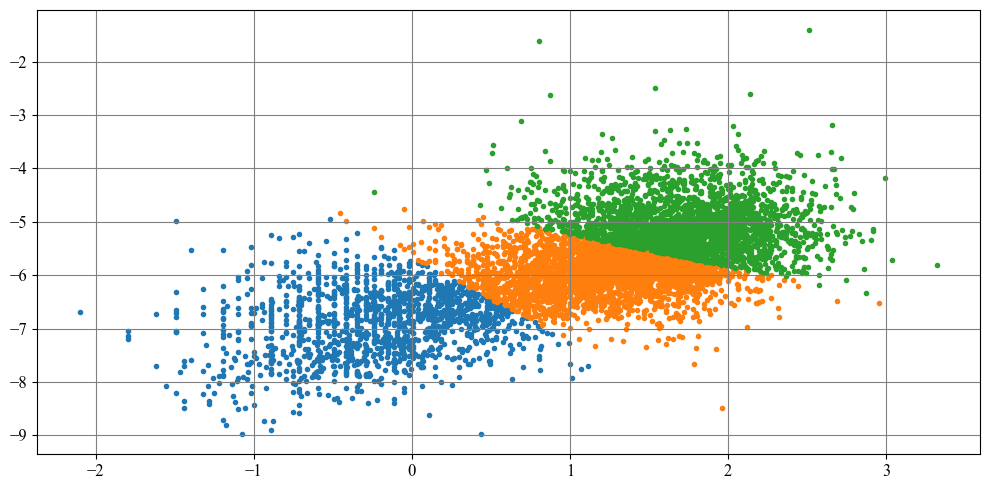

In [62]:
for i in np.unique(labels):
    plt.scatter(X[labels==i].T[0],X[labels==i].T[1],marker='.')

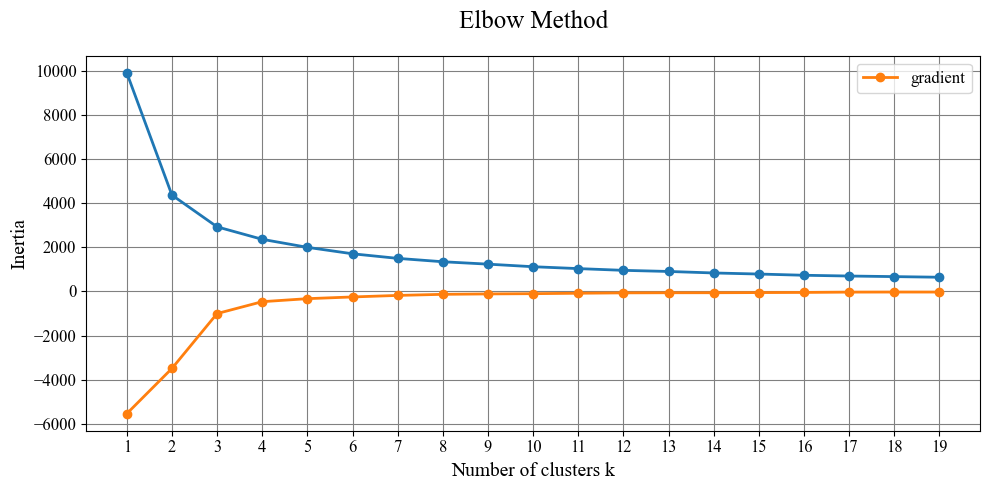

In [63]:
inertia = []
k_range = range(1, 20)  # Try between 1 and 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot
plt.plot(k_range, inertia, 'o-')
plt.plot(k_range,np.gradient(inertia), 'o-', label='gradient')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.xticks(k_range)
plt.legend()


In [64]:
from sklearn.mixture import GaussianMixture

bic_scores = []
n_components_range = range(1, 21)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))


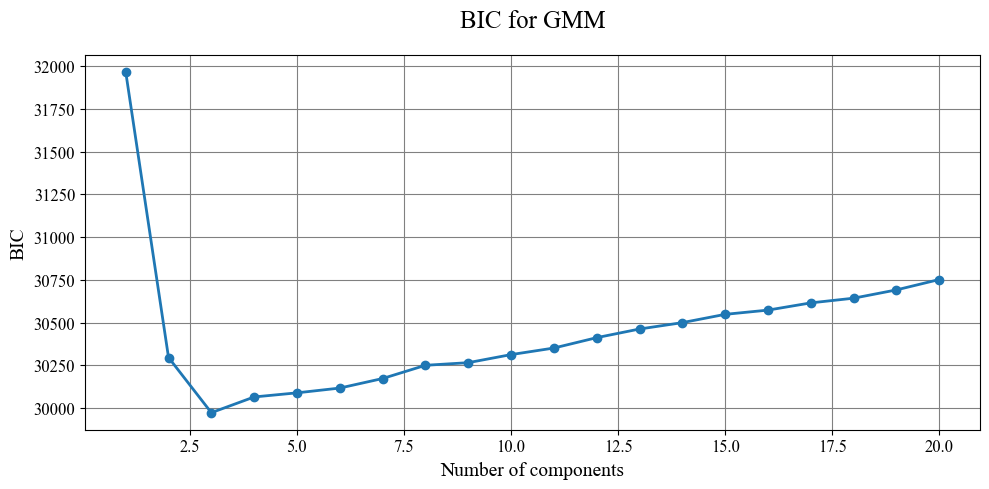

In [65]:
# Plot BIC
plt.plot(n_components_range, bic_scores, 'o-')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC for GMM')
plt.show()

In [66]:
best_n_components = 3
print(f"Best number of clusters: {best_n_components}")

Best number of clusters: 3


In [67]:
best_gmm = GaussianMixture(n_components=best_n_components, random_state=0)
labels = best_gmm.fit_predict(X)

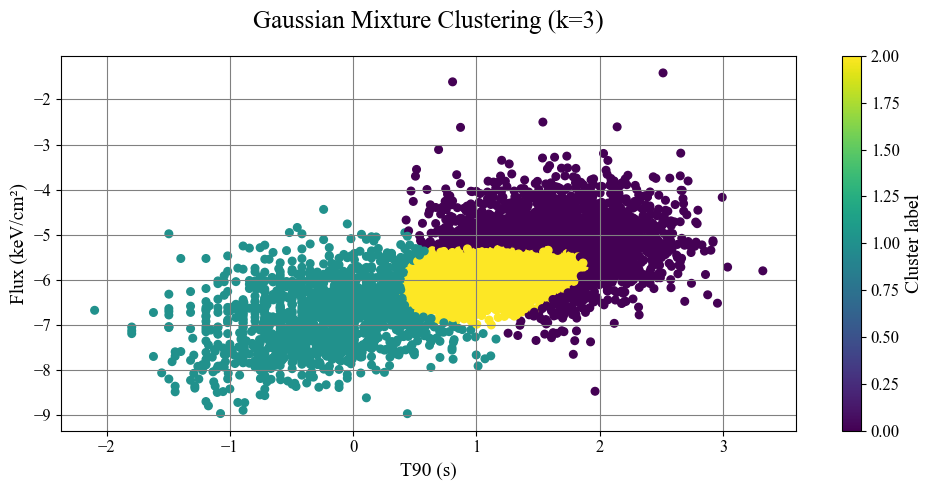

In [68]:
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.xlabel('T90 (s)')
plt.ylabel('Flux (keV/cm²)')
plt.title(f'Gaussian Mixture Clustering (k={best_n_components})')
plt.colorbar(label='Cluster label')